# Speeding up your code with Cython

Cython allows you to write C extensions to Python in a very pythonic manner. In this notebook we'll explore the syntax of Cython and see what kind of speed up we can achieve.

Cython provides an extension for IPython notebooks that makes working with Cython very convenient. If you enter `%load_ext Cython` the `%%cython` magic becomes available.

In [1]:
%load_ext Cython

In [2]:
import numpy as np

Let us start with something simple. The following function calculates the dot product between two vectors:

In [3]:
def pydot(v, w):
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

In [4]:
v = np.arange(0, 10000, dtype=int)
w = np.arange(0, 10000, dtype=int)

In [5]:
%%timeit a = range(10000); b = range(10000)
pydot(a, b)

100 loops, best of 3: 3.18 ms per loop


In [6]:
pydot_timing = %timeit -o pydot(v, w)

100 loops, best of 3: 2.83 ms per loop


Now let us invoke Cython

In [7]:
%%cython
def dot(v, w):
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

In [8]:
%%timeit a = range(10000); b = range(10000)
dot(a, b)

100 loops, best of 3: 2.71 ms per loop


In [9]:
dot1_timing = %timeit -o dot(v, w)

1000 loops, best of 3: 1.67 ms per loop


We can check what Cython does by invoking the cell magic with the option `-a`.

In [10]:
%%cython -a
def dot(v, w):
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

This produces an annotated listing. The darker the yellow, the more Python code is in that line. You can click on each line to see the C code that was generated for. Go ahead and explore.

There are many references to Python objects and functions. Basically, you only save the overhead of interpreting. Let's see if we can do a little better.

## Declaring types

The arguments `v` and `w` are very general. If we know, however, that we are only going to pass ndarrays of integers, we can be more specific:

In [46]:
%%cython
import numpy as np
cimport numpy as np

def dot(np.ndarray[np.int_t, ndim = 1] v, np.ndarray[np.int_t, ndim = 1] w):
    cdef long res = 0
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

In [47]:
dot2_timing = %timeit -o dot(v, w)

The slowest run took 5.49 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 14.2 µs per loop


In [48]:
%%cython -a
import numpy as np
cimport numpy as np

def dot(np.ndarray[np.int_t, ndim = 1] v, np.ndarray[np.int_t, ndim = 1] w):
    cdef long res = 0
    if len(v) == len(w) and len(v) > 0:
        res = v[0] * w[0]
        for i in range(1, len(v)):
            res += v[i] * w[i]
    return res

`len(v)` is a Python call. It can be pulled out and assigned to an integer variable.

In [49]:
%%cython
import numpy as np
cimport numpy as np

def dot(np.ndarray[np.int_t, ndim = 1] v, np.ndarray[np.int_t, ndim = 1] w):
    cdef long res = 0
    cdef int n = 0
    n = len(v)
    if n > 0 and n == len(w):
        for i in range(0, n):
            res += v[i] * w[i]
    return res

In [50]:
dot3_timing = %timeit -o dot(v, w)

The slowest run took 5.62 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 10.4 µs per loop


In [52]:
%%cython -a
import numpy as np
cimport numpy as np

def dot(np.ndarray[np.int_t, ndim = 1] v, np.ndarray[np.int_t, ndim = 1] w):
    cdef long res = 0
    cdef int n = 0
    n = len(v)
    if n > 0 and n == len(w):
        for i in range(0, n):
            res += v[i] * w[i]
    return res

If you look at line 10, you'll notice that there are some bounds checks, but they are unnecessary since we check the bounds beforehand already. Let's do away with them.

In [53]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in range(1, n):
            res += v[i] * w[i]
        return res

In [54]:
dot4_timing = %timeit -o dot(v,w)

The slowest run took 5.56 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 11.1 µs per loop


In [56]:
%%cython -a
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in range(1, n):
            res += v[i] * w[i]
        return res

In [57]:
%%cython
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in range(1, n):
            res += v[i] * w[i]
        return res

In [58]:
dot5_timing = %timeit -o dot(v,w)

The slowest run took 10.12 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.27 µs per loop


In [59]:
%%cython -a --compile-args=-O2 --compile-args=-march=native --force
import numpy as np
cimport numpy as np
cimport cython
@cython.boundscheck(False)
@cython.wraparound(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = 0
        for i in range(0, n):
            res += v[i] * w[i]
        return res

In [24]:
%%cython  --compile-args=-fopenmp --compile-args=-O2 --compile-args=-march=native --link-args=-fopenmp --force
import numpy as np
cimport numpy as np
cimport cython
from cython.parallel import parallel, prange

@cython.boundscheck(False)
@cython.wraparound(False)
def dot(np.ndarray[np.int64_t, ndim = 1] v, np.ndarray[np.int64_t, ndim = 1] w):
    cdef long res
    cdef int i
    cdef int n
    n = len(v)
    if n > 0 and n == len(w):
        res = v[0] * w[0]
        for i in prange(1, n, nogil=True):
            res += v[i] * w[i]
        return res

In [60]:
dot6_timing = %timeit -o dot(v,w)

The slowest run took 14.41 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 8.08 µs per loop


Numba, can generate fast functions, too.

In [69]:
from numba import int64, jit
@jit(nopython=True)
def udot(v, w):
    res = 0
    n = len(v)
    for i in range(0, n):
        res += v[i] * w[i]
    return res

In [70]:
from numba import int64, jit
@jit(nopython=False)
def udotg(v, w):
    res = 0
    for i in range(0, len(v)):
        res += v[i] * w[i]
    return res

In [73]:
numbadot_timing = %timeit -o udot(v,w)

The slowest run took 6.77 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.41 µs per loop


In [74]:
numbadotg_timing = %timeit -o udotg(v,w)

The slowest run took 7.43 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.41 µs per loop


In [76]:
%%timeit a = range(10000); b = range(10000)
udotg(a,b)

100 loops, best of 3: 3.49 ms per loop


In [77]:
npdot_timing = %timeit -o np.dot(v,w)

The slowest run took 61.05 times longer than the fastest. This could mean that an intermediate result is being cached.
100000 loops, best of 3: 7.67 µs per loop


In [79]:
%%timeit a = range(10000); b = range(10000)
np.dot(a,b)

100 loops, best of 3: 3.57 ms per loop


In [80]:
tunits = {'ns':10**-9, 'us':10**-6, 'ms':10**-3, 's':1.0}
timers = [pydot_timing, dot1_timing, dot2_timing, dot3_timing, dot4_timing, dot5_timing, 
         dot6_timing, numbadot_timing, numbadotg_timing, npdot_timing]
times = np.array([t.best for t in timers])

In [81]:
%matplotlib inline
import matplotlib.pyplot as plt

([<matplotlib.axis.XTick at 0x2aebf0fb8208>,
 <a list of 8 Text xticklabel objects>)

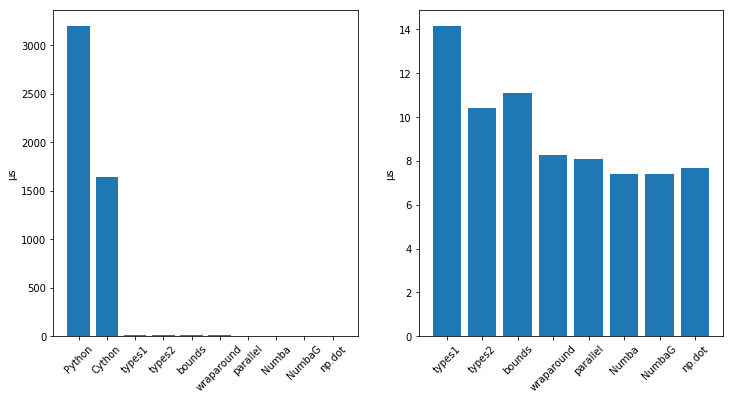

In [82]:
plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.bar(np.arange(len(times)) + 1, times * 1e6)
plt.ylabel(u"µs")
plt.xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10],["Python", "Cython", "types1", "types2", "bounds", "wraparound", "parallel", 
                                  "Numba", "NumbaG", "np.dot"], rotation=45)
plt.subplot(1,2,2)
plt.bar(np.arange(2, len(times[2:]) + 2) + 1, times[2:] * 1e6)
plt.ylabel(u"µs")
plt.xticks([3, 4, 5, 6, 7, 8, 9, 10],["types1", "types2", "bounds", "wraparound", "parallel", 
                                  "Numba", "NumbaG", "np.dot"], rotation=45)

In [83]:
v = np.arange(10000000, dtype=int)
w = np.arange(10000000, dtype=int)
%timeit -n 1 pydot(v,w)
%timeit dot(v,w)
%timeit udot(v,w)
%timeit np.dot(v,w)

/usr/local/software/jureca/Stages/2017a/software/SciPy-Stack/2017a-intel-para-2017a-Python-3.6.1/lib/python3.6/site-packages/ipykernel/__main__.py:5: RuntimeWarning: overflow encountered in long_scalars


1 loop, best of 3: 3.18 s per loop
100 loops, best of 3: 12.7 ms per loop
100 loops, best of 3: 11.8 ms per loop
100 loops, best of 3: 12.3 ms per loop


The following video is from a half-day tutorial on Cython.

from IPython.display import YouTubeVideo
YouTubeVideo("gMvkiQ-gOW8")